# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:10<00:00, 2260.21it/s]


In [23]:
preprocessed_reviews[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

# [4] Featurization

# [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


# [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2V

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# Obtaining the Required DataFrame:

In [24]:
type(preprocessed_reviews)

list

In [25]:
print(final.shape)

(160176, 10)


We obtain a list at the end of all the Preprocessing whereas the data frame that we obtained at the end was named 
'final'. Initially I considered 200K datapoints to work upon which got reduced to approx. 160K datapoints after all 
the text processing and data deduplication.

Out of these 160K datapoints in total we will consider only 100K points to be applied to the Truncated SVD Algorithm.

In [26]:
final['Preprocessed_Reviews'] = preprocessed_reviews

Basically I have taken the entire list and added the list as a column to the entire dataframe, such that each value
corresponds to a row in the dataframe. 

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


Now I have a total of approx. 160K rows in the dataframe called 'final', of which I will consider only 100K rows to
be applied to the Truncated SVD algorithm. 

Also here you have the Unix Timestamp in the data, which is basically the time when the review was posted. This would have helped us to carry out Time Based Split of the data into Train, CV and Test in the case of the Supervised Learning schemes of Classification & Regression, but we do not do so in the case of Unsupervised Learning schemes.

# Further Data Processing :- 

First I will remove all the useless columns from my dataframe. The only columns that we are concerned about here in 
this case is the 'Preprocessed_Reviews' (Without carrying out any Feature Engineering). Remaining columns 
in the dataframe are of no use to us. 

Note :- Even 'Score' as a column is of no use to us because 'Score' basically refers to our class labels, something which are of no use to us when we are carrying out Matrix Factorization.

In [28]:
tfidf_df = final[['Preprocessed_Reviews']][:100000]

In [29]:
tfidf_df.head()

,Preprocessed_Reviews
138695,remembered book childhood got kids good rememb...
138707,daughter loves really rosie books introduced r...
138708,one best children books ever written mini vers...
138686,entertaining rhyming story cleaver catchy illu...
138685,grand daughter favorite book read loves rhythm...


# [5.1] Applying Truncated SVD :-

# [5.1.1] Taking Top Features from TFIDF Featurization :-

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10)
TFIDF_Trunc_SVD = tf_idf_vect.fit_transform(tfidf_df['Preprocessed_Reviews']) 

#fit_transform internally considers the parameters that will be used for transforming the data from the text to a 
#numerical vector and then carries out the Transformation

In [31]:
TFIDF_Trunc_SVD.shape

(100000, 12467)

In [32]:
len(tf_idf_vect.idf_)

12467

Basically in the TFIDF Featurization that has been carried out above, I have only considered uni-grams, ie only the individual words are considered from our 'Preprocessed_Reviews' which is then converted to the Vector form and stored in the variable 'TFIDF_Trunc_SVD'. 

Also when you consider 100K reviews in total, we obtain a total of 12467 words, and corresponding 12467 idf scores. 

Out of these 12467 IDF Values, we pick the Top 3000 Values and the Corresponding words which is achieved as follows:

* From the TFIDF Vectorization that we carried out, obtain the IDF for all the words by calling the idf_ method. You get a numpy array which is converted to a list and stored in a variable called idf_scores. 
* Now sort the values and the obtain the indices for words in the ascending order of their importance. Therefore in order to obtain the Top 3000 words with the Highest IDF Values, flip the array and then take the first 3000 Words, which are stored in a variable called 'most_important_top3000'.

In [33]:
idf_scores = tf_idf_vect.idf_.tolist()
asc_sort_idf_scores = np.argsort(idf_scores)
desc_sort_idf_scores = np.flip(asc_sort_idf_scores)

tfidf_feature_names = tf_idf_vect.get_feature_names()

In [34]:
most_important_top3000=[]
    
for i in desc_sort_idf_scores[:3000]:
    most_important_top3000.append(tfidf_feature_names[i])

In [35]:
print("Some of the Most Important Features with the Highest IDF Values are as follows:")
print(" ")
print(most_important_top3000[:5])

Some of the Most Important Features with the Highest IDF Values are as follows:
 
['orlando', 'purveyors', 'multipack', 'scandinavian', 'scales']


# [5.2] Calulation of Co-Occurrence Matrix :-

We need to obtain our Co-Occurrence matrix X which is basically an (nXn) square matrix where n=3000 ie. all the Word combinations that are possible in 'most_important_top3000', where the element in the cell Xij is the number of times 
word w_i occurs in the Context of w_j in our corpus.

We are considering the Top 3000 Words because instead of that if we considered all the 50K+ Words, carrying out Truncated SVD would have been expensive. 

In order to achieve the same we first define a (3000 X 3000) Zero matrix which we will update according to the context count that we obtain.

In [36]:
tfidf_matrix = np.zeros((3000,3000))

In [37]:
tfidf_matrix.shape

(3000, 3000)

We first obtain all of our individual reviews in a list so that we can loop through each review seamlessly :

In [39]:
Reviews_list = []

#Each Review is appended to a list.
for i in tfidf_df['Preprocessed_Reviews']:
    Reviews_list.append(i)

<b> <font color="black"> Function to obtain All the Words in a Particular Review as a List :- </font> </b>

In [40]:
def review_wordlist(Review_index):
    res1=[]
    res1 = re.findall(r'\w+', Reviews_list[Review_index]) #splitting basis the whitespaces
    
    return res1

The need for this is explained as follows:
 
 * When we defined our TFIDF Vectorizer, we have considered only the uni-grams, and it is to be noted that 
   the Top 3000 features that we obtained consists of only uni-grams which need to be
   considered when we are trying to obtain our Context.  
 * Therefore, for a sentence such as the following :
    'Hello I like deep learning and ML'.
    
    We obtain a list as follows in the Function output :-  ['Hello','I','like','deep','learning','and','ML']

<b> <font color="black"> Calling the Function to obtain all the Words in a Particular Review as a List:- </font> </b>

In [41]:
res2=[]

for k in range(100000):
    res2.append(review_wordlist(k))    

<b> <font color="black"> Function to obtain all the Words in Context given an Input Word  :- </font> </b>

In [42]:
def words_in_context(input_list,focus_word):
    for i in input_list:
        focusword_index = input_list.index(focus_word)
    res3=[]
    
    if focusword_index == 0 or focusword_index == 1:
        res3 = input_list[:5]
    elif focusword_index == (len(input_list)-1) or focusword_index == (len(input_list)-2) :
        res3 = input_list[len(input_list)-5:]
    else:
        for k in range(-2,3):
            res3.extend([input_list[focusword_index+k]])
    
    return res3                

Basically, Context is explained as follows :- 

* Given a particular review text, a word w_j is in the context of the word w_i if both of these words are within the Neighbourhood of each other. Neighbourhood could be different values in different scenarios. However, in our case we take a Neighbourhood Value of 5. 
* Therefore given a list ['I','am','passionate','about','ML','and',deep',learning'], and your focus word being the last or second last words ('deep' or 'learning') you need to return the last 5 words. (Vice-versa when the word is at index = 0 or 1). 
* Otherwise you need to return the previous 2 Words,focus word and the next 2 words, which basically becomes our Context.

<b> <font color="black"> Obtaining the Co-Occurrence Matrix :- </font> </b>

In [43]:
j=0

while j<100000: #for all the reviews in the Dataframe
    for word1 in res2[j]: #for each word1 in the Bi-Gram Review
        if word1 in most_important_top3000: # if word1 is present in most_important_top3000
            word1_index = most_important_top3000.index(word1) #obtain the index of that particular word -> word1
            context = words_in_context(res2[j],word1) #Call the function. Returns list of words in context
            for word2 in context:   #for each word2 in context
                if word2 in most_important_top3000:  #if word2 is present in most_important_top3000 
                    word2_index = most_important_top3000.index(word2)  
                    #obtain the index of that particular word -> word2
                    tfidf_matrix[word1_index][word2_index] +=1 #increment the intersecting cell
    j=j+1

In [44]:
np.count_nonzero(tfidf_matrix)

5572

Initially we had a (3000 X 3000) matrix ie. a total of 9000 zero elements, out of which whereever the context condition is met, we increment that particular cell, and hence we notice that 5572 elements now are non-zero in the matrix.  

# [5.3] Finding Optimal Value for Number of Components (n) to be Retained :-

In [45]:
from sklearn.decomposition import TruncatedSVD #Importing the Required Package 

trunc_SVD = TruncatedSVD(n_components=2999,algorithm ='randomized',n_iter=5)
trunc_SVD.fit(tfidf_matrix) #Co-Occurrence Matrix is provided as the input

svd_variance_explained = trunc_SVD.explained_variance_ratio_ 
#explained_variance_ratio_ is a method that returns an array with the value of variance explained by that particular
#feature.

<b> <font color="black"> Function to Obtain the Ideal Number of Components :- </font> </b>

In [46]:
def ideal_component(component_variance_vector,target_variance):

    achieved_variance=0
    n_components = 0
    
    for var in svd_variance_explained:
            achieved_variance += var
            n_components += 1
            if achieved_variance >= target_variance:
                 break;
    return n_components        

This function is explained as follows :-

* We define a function that takes 2 parameters :- The variance vector that we obtained in the previous cell (svd_variance_explained) and the target_variance that we want to achieve by our features.
* Initially both n_components and the achieved_variance is 0. achieved_variance keeps on adding while passing through the variance list after every iteration, and as soon as this value exceeds our target_variance provided, the loop is exited and that number becomes our n_components.  

Therefore in our case we want at least 90% variance, which can be explained not by 3000, but only 2437 features, as shown below.

In [47]:
ideal_component(svd_variance_explained,0.90)

2332

Now we decompose and transform the (nXn) matrix into u^ ie. our (nXk) matrix where k = 2332, that explains 90% of our
total variance. This is basically stored in a variable called 'transformed_SVD'.

In [48]:
trunc_SVD_final = TruncatedSVD(n_components=2332,algorithm ='randomized',n_iter=5)
transformed_SVD = trunc_SVD_final.fit_transform(tfidf_matrix) 

In [49]:
transformed_SVD.shape

(3000, 2332)

# [5.4] Applying K-Means Clustering :-

# Hyperparameter Tuning on the TFIDF Representation :- 

In [50]:
#Importing the Required Packages for K-Means

from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt  
from tqdm import tqdm

In order to carry out the Hyperparameter Tuning we need to work upon the Number of Clusters that we should obtain(K) after initializing K Centroids, and this is basically taken in the range of (2,50). This Hyperparameter Tuning is carried out by plotting the inertia (Loss Function for K-means vs the Count of Clusters).

Again, here we take n_init ie the number of initializations to be equal to 10 ie the initialization will be carried out 10 times and max_iter=200. This means that the iterations keep occuring till the defined tolerance level is achieved ie. the distance between the final centroid and the semi-final centroid is > tolerance.

In [51]:
K_hyperparam =[]

for i in range(2,50,5):
    K_hyperparam.append(i)

In [52]:
TFIDF_inertia = []

for k in tqdm(K_hyperparam):
    TFIDF_KMModel = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=200,tol=0.0001,
                      random_state=0,n_jobs=-1,algorithm='auto')
    # I have taken n_jobs=-1 so as to parallelise the entire execution. A specification of -1 in this scenario
    # means to use all the processors that are available.
    
    TFIDF_KMModel.fit(transformed_SVD)
    TFIDF_squared_distance_sum = TFIDF_KMModel.inertia_
    TFIDF_inertia.append(TFIDF_squared_distance_sum)    

100%|██████████| 10/10 [00:58<00:00,  8.39s/it]


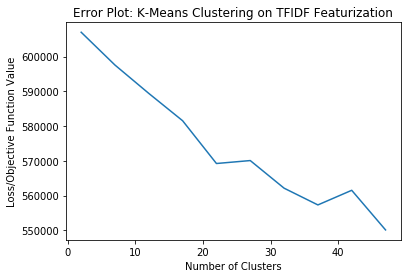

In [53]:
#Plotting the Values of Inertia (Objectve/Loss Function) for different values of K:-

plt.plot(K_hyperparam,TFIDF_inertia)

plt.xlabel('Number of Clusters')
plt.ylabel('Loss/Objective Function Value')
plt.title('Error Plot: K-Means Clustering on TFIDF Featurization')

plt.show()

Here you are obtaining the Best Value of K by plotting the Loss Function for K-Means vs the Number of Clusters. This best value is basically obtained by the Elbow Plot and finding the value of K where the first bend in the curve actually begins.

As we see here, K=17 is a good value to be taken for the n_clusters as a parameter in KMeans.

In [54]:
TFIDF_optimal_k=17

# [5.5] Wordclouds of clusters obtained in K-Means Clustering :-

In [55]:
import time
start = time.time()

#Training our Data on the Final TFIDF Model obtained on K-Means
TFIDF_KMeans_final = KMeans(n_clusters=TFIDF_optimal_k,init='k-means++',n_init=10,max_iter=200,tol=0.0001,
                          random_state=0,n_jobs=-1,algorithm='auto')
TFIDF_KMeans_final.fit(transformed_SVD)

end = time.time()
print("Time consumed (in min) in Training the model on the Optimal K using TFIDF Featurization "
       , np.round((end - start)/60,2))

Time consumed (in min) in Training the model on the Optimal K using TFIDF Featurization  0.07


<b> <font color="black"> Function to obtain the Cluster Value Indices & Cluster Length given the Final Model & Cluster & Label:- </font> </b>

In [56]:
def Review_Cluster(final_data,k,cluster_name):
    
    for i,j in enumerate(final_data.labels_):
        if j==k:
            cluster_name.append(i)
    cluster_length = len(cluster_name)
    return cluster_name,cluster_length

<b> <font color="black"> Calling the Review_Cluster() Function on the TFIDF Model:- </font> </b>

In [57]:
TFIDF_C0 = []
TFIDF_C1 = []
TFIDF_C2 = []
TFIDF_C3 = []
TFIDF_C4 = []
TFIDF_C5 = []
TFIDF_C6 = []
TFIDF_C7 = []
TFIDF_C8 = []
TFIDF_C9 = []
TFIDF_C10 = []
TFIDF_C11 = []
TFIDF_C12 = []
TFIDF_C13 = []
TFIDF_C14 = []
TFIDF_C15 = []
TFIDF_C16 = []


TFIDF_indices_C0,TFIDF_length_C0   =    Review_Cluster(TFIDF_KMeans_final,0,TFIDF_C0)
TFIDF_indices_C1,TFIDF_length_C1   =    Review_Cluster(TFIDF_KMeans_final,1,TFIDF_C1)
TFIDF_indices_C2,TFIDF_length_C2   =    Review_Cluster(TFIDF_KMeans_final,2,TFIDF_C2)
TFIDF_indices_C3,TFIDF_length_C3   =    Review_Cluster(TFIDF_KMeans_final,3,TFIDF_C3)
TFIDF_indices_C4,TFIDF_length_C4   =    Review_Cluster(TFIDF_KMeans_final,4,TFIDF_C4)
TFIDF_indices_C5,TFIDF_length_C5   =    Review_Cluster(TFIDF_KMeans_final,5,TFIDF_C5)
TFIDF_indices_C6,TFIDF_length_C6   =    Review_Cluster(TFIDF_KMeans_final,6,TFIDF_C6)
TFIDF_indices_C7,TFIDF_length_C7   =    Review_Cluster(TFIDF_KMeans_final,7,TFIDF_C7)
TFIDF_indices_C8,TFIDF_length_C8   =    Review_Cluster(TFIDF_KMeans_final,8,TFIDF_C8)
TFIDF_indices_C9,TFIDF_length_C9   =    Review_Cluster(TFIDF_KMeans_final,9,TFIDF_C9)
TFIDF_indices_C10,TFIDF_length_C10 =    Review_Cluster(TFIDF_KMeans_final,10,TFIDF_C10)
TFIDF_indices_C11,TFIDF_length_C11 =    Review_Cluster(TFIDF_KMeans_final,11,TFIDF_C11)
TFIDF_indices_C12,TFIDF_length_C12 =    Review_Cluster(TFIDF_KMeans_final,12,TFIDF_C12)
TFIDF_indices_C13,TFIDF_length_C13 =    Review_Cluster(TFIDF_KMeans_final,13,TFIDF_C13)
TFIDF_indices_C14,TFIDF_length_C14 =    Review_Cluster(TFIDF_KMeans_final,14,TFIDF_C14)
TFIDF_indices_C15,TFIDF_length_C15 =    Review_Cluster(TFIDF_KMeans_final,15,TFIDF_C15)
TFIDF_indices_C16,TFIDF_length_C16 =    Review_Cluster(TFIDF_KMeans_final,16,TFIDF_C16)

<b> <font color="black"> Function to obtain the WordCloud for the Featurization given the Relevant Cluster Indices :- </font> </b>

In [58]:
def Show_Wordcloud(clustered_indices,topidf_wordlist):
    reviews_in_cluster = set()
    empty_str = ' '
    
    for i in clustered_indices:
        reviews_in_cluster.add(topidf_wordlist[i])
    
    reviews_string = empty_str.join(reviews_in_cluster)
    
    wordcloud_featurization = WordCloud(width = 1100, height = 600, background_color ='black',  
                                        min_font_size =8).generate(reviews_string)

    # Display the generated image:
    plt.figure(figsize = (25, 15), facecolor = None) 
    plt.imshow(wordcloud_featurization)
    plt.axis("off")
    plt.show()

<b> <font color="black"> Obtaining Word Clouds for the Individual Clusters for TFIDF Featurization :- </font> </b>

Here it is to be noted that the Cluster Labelling over here starts from 0 and hence the labels for the 17 clusters will be [0-16].

Number of Reviews Classified into Cluster 0: 2984
 
Cluster 0 obtained by TFIDF Featurization:


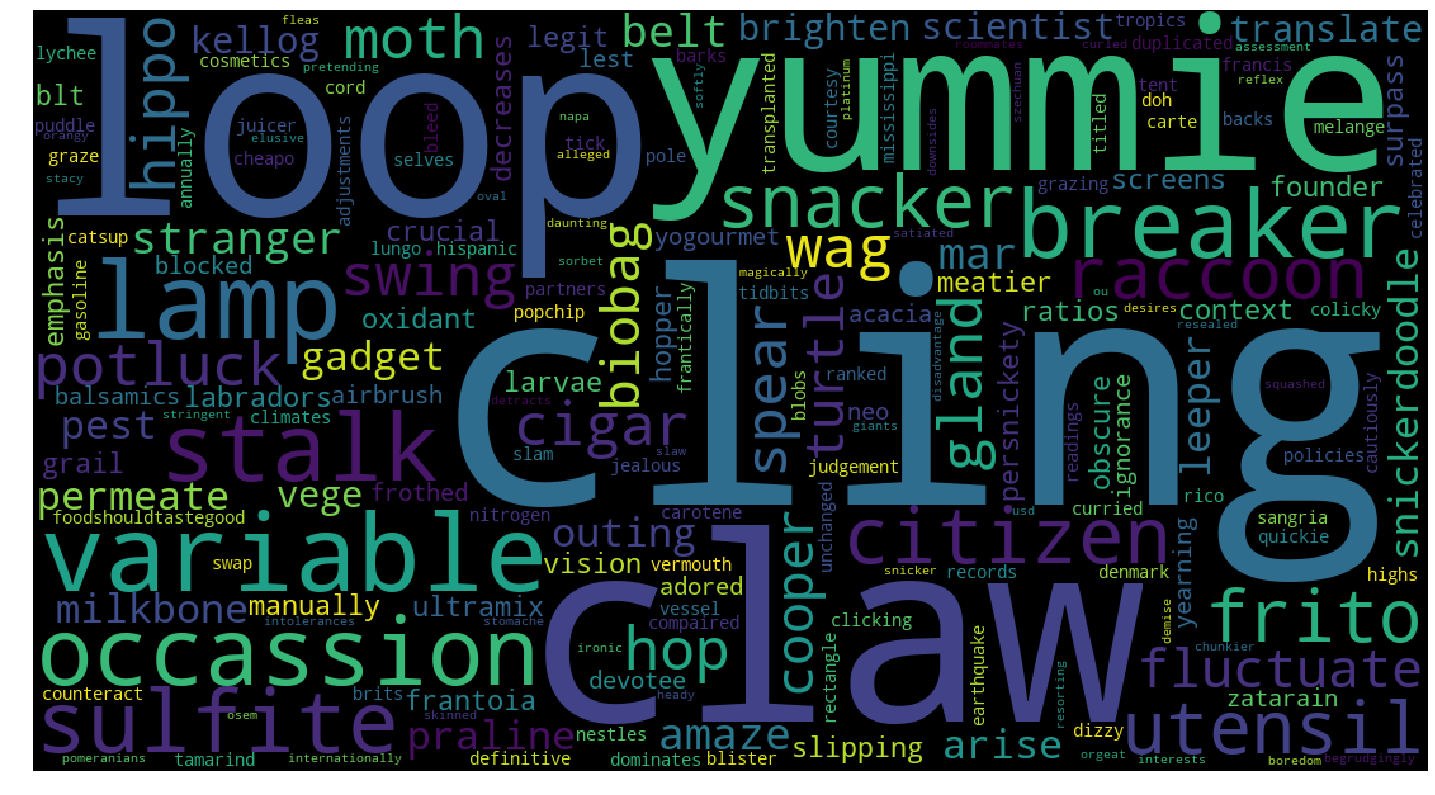

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 0 obtained by TFIDF Featurization : 0.04


In [59]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 0: " + str(TFIDF_length_C0))
print(" ")
print("Cluster 0 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C0,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 0 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Number of Reviews Classified into Cluster 1: 1
 
Cluster 1 obtained by TFIDF Featurization:


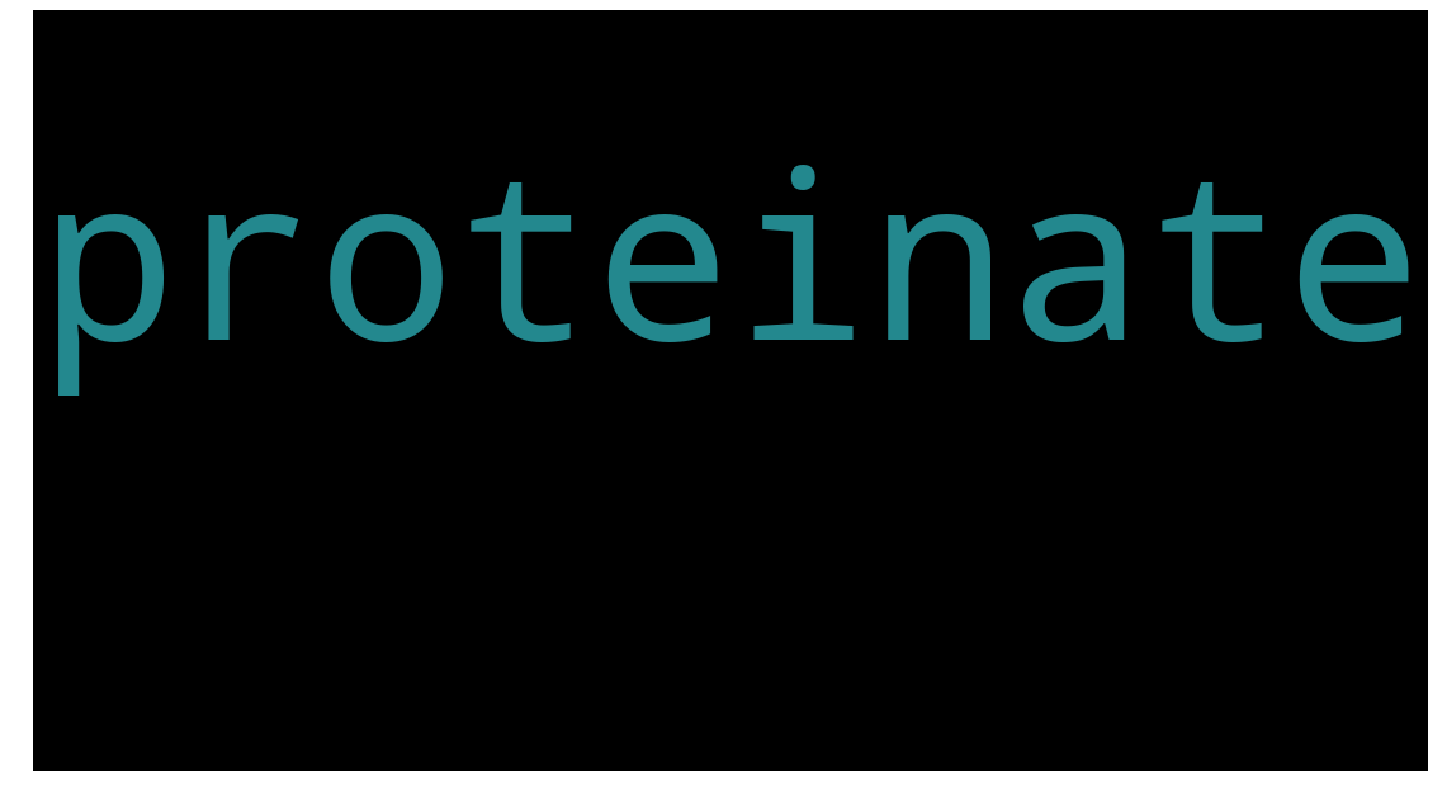

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 1 obtained by TFIDF Featurization : 0.01


In [60]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 1: " + str(TFIDF_length_C1))
print(" ")
print("Cluster 1 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C1,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 1 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Number of Reviews Classified into Cluster 2: 1
 
Cluster 2 obtained by TFIDF Featurization:


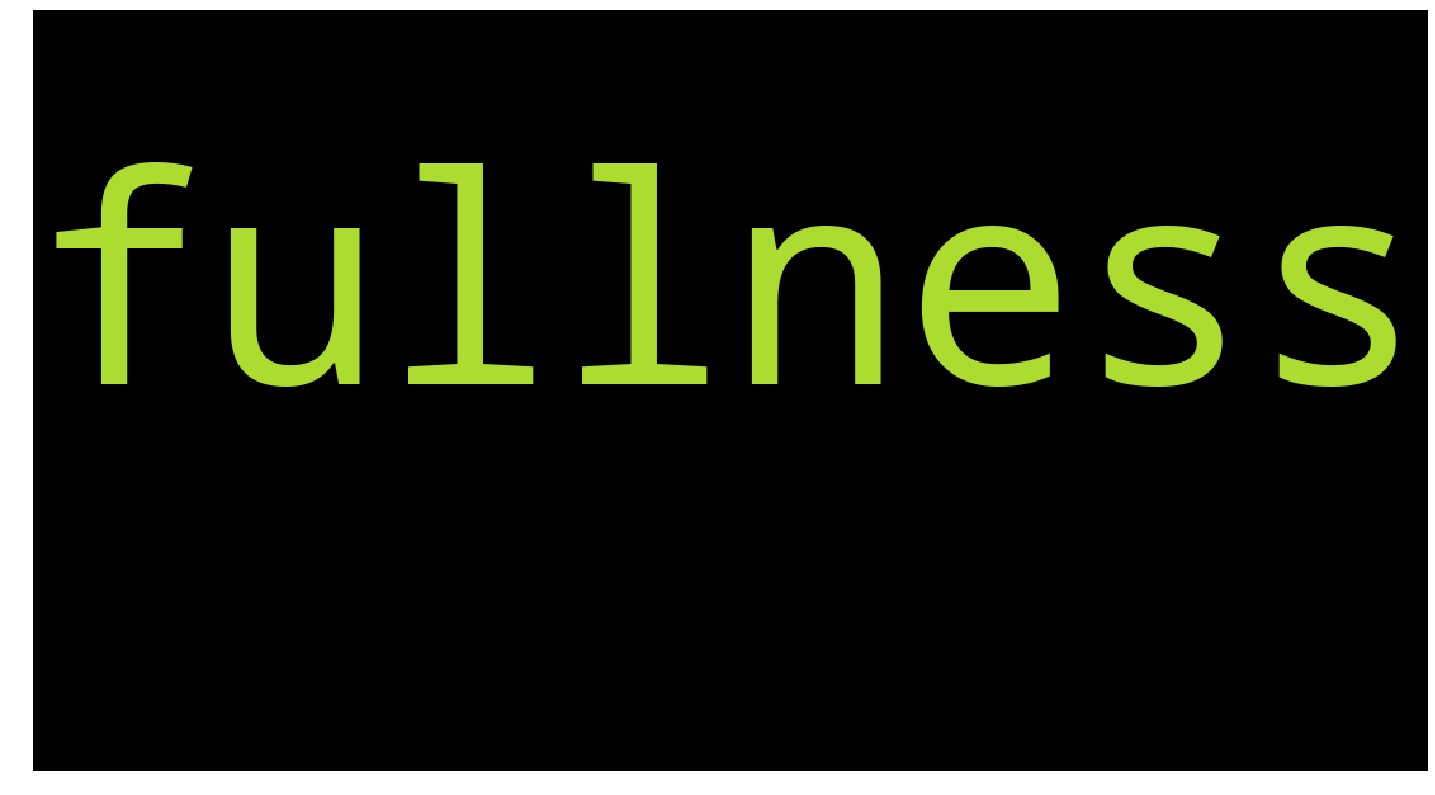

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 2 obtained by TFIDF Featurization : 0.01


In [61]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 2: " + str(TFIDF_length_C2))
print(" ")
print("Cluster 2 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C2,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 2 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Number of Reviews Classified into Cluster 3: 1
 
Cluster 3 obtained by TFIDF Featurization:


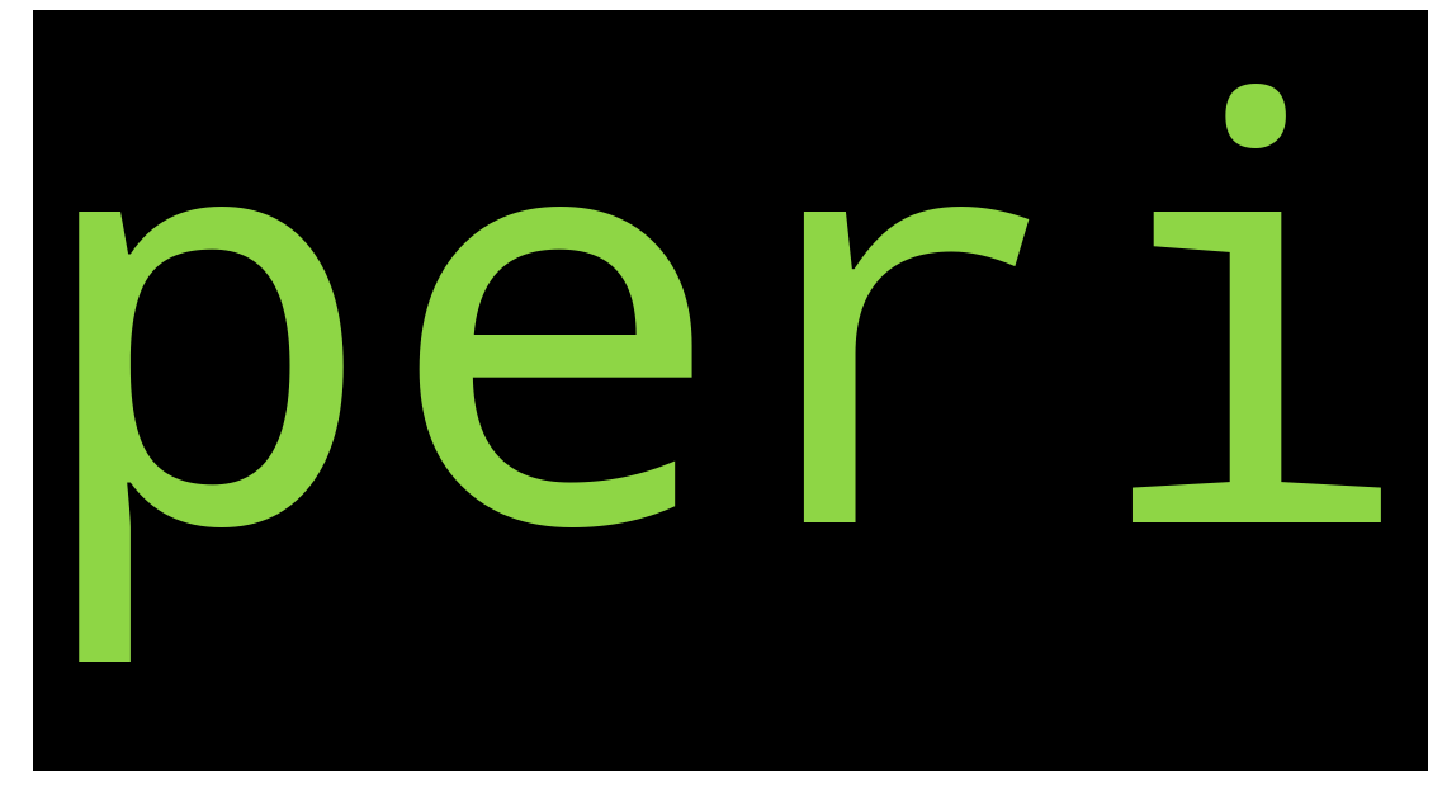

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 3 obtained by TFIDF Featurization : 0.01


In [62]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 3: " + str(TFIDF_length_C3))
print(" ")
print("Cluster 3 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C3,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 3 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Number of Reviews Classified into Cluster 4: 1
 
Cluster 4 obtained by TFIDF Featurization:


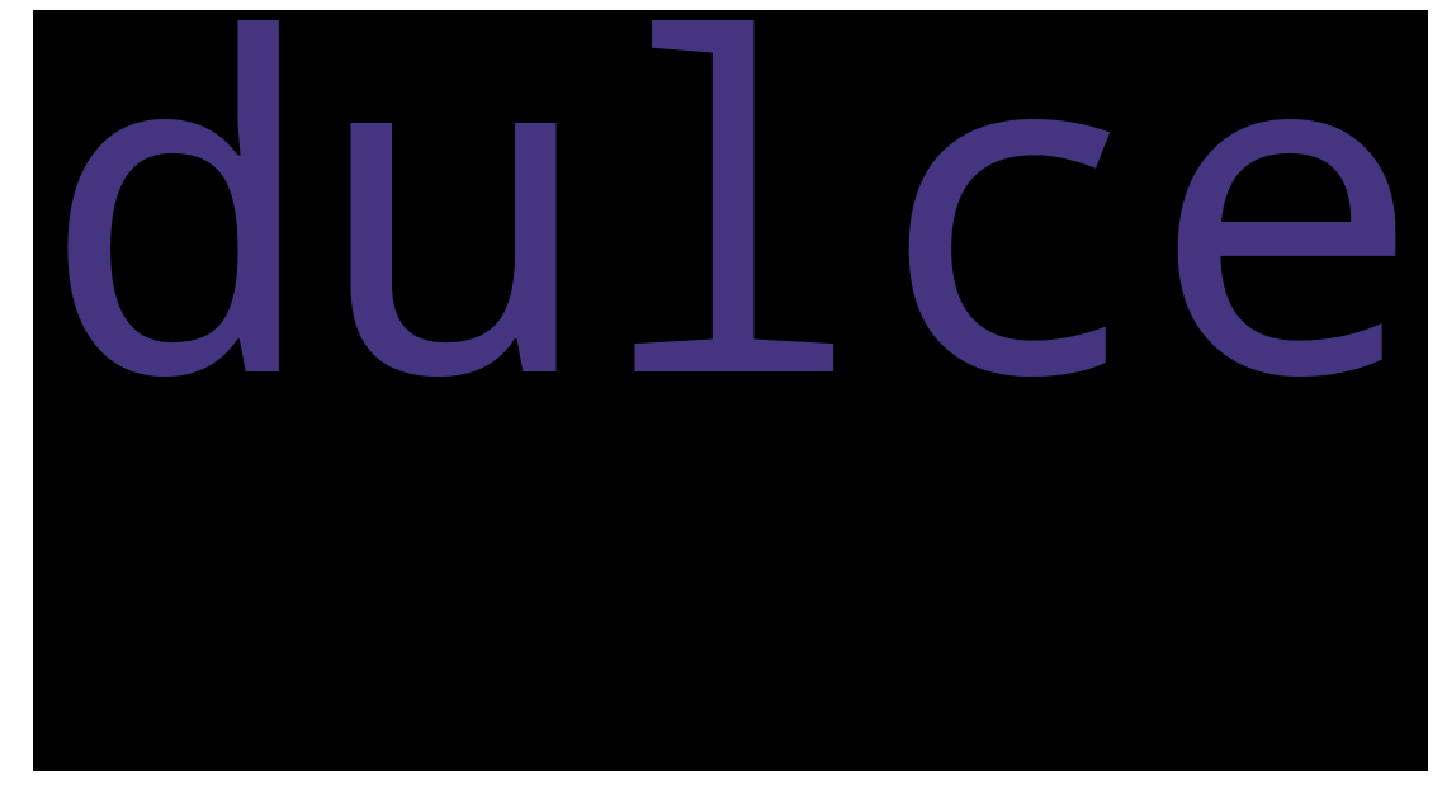

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 4 obtained by TFIDF Featurization : 0.01


In [63]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 4: " + str(TFIDF_length_C4))
print(" ")
print("Cluster 4 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C4,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 4 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Number of Reviews Classified into Cluster 5: 1
 
Cluster 5 obtained by TFIDF Featurization:


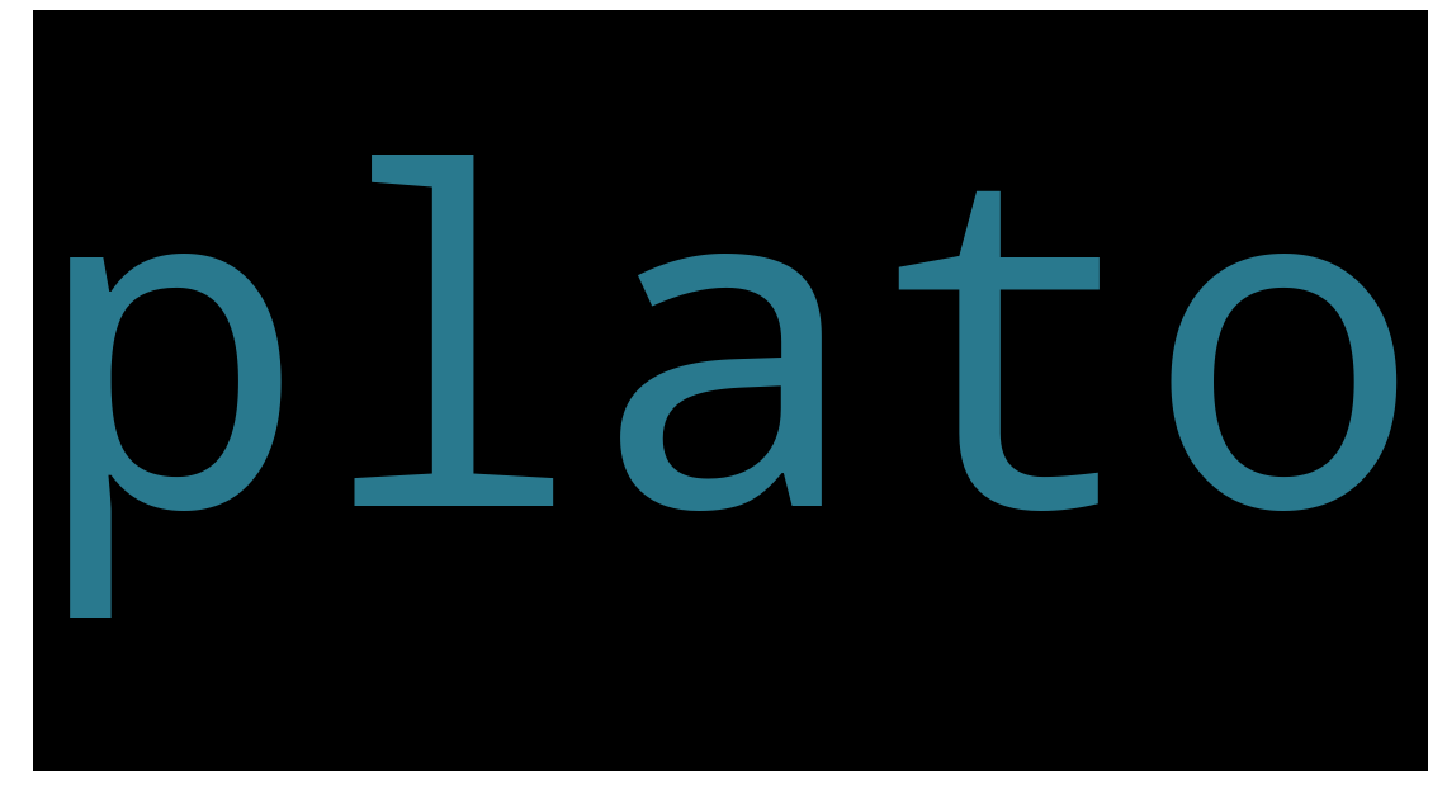

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 5 obtained by TFIDF Featurization : 0.01


In [64]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 5: " + str(TFIDF_length_C5))
print(" ")
print("Cluster 5 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C5,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 5 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Number of Reviews Classified into Cluster 6: 1
 
Cluster 6 obtained by TFIDF Featurization:


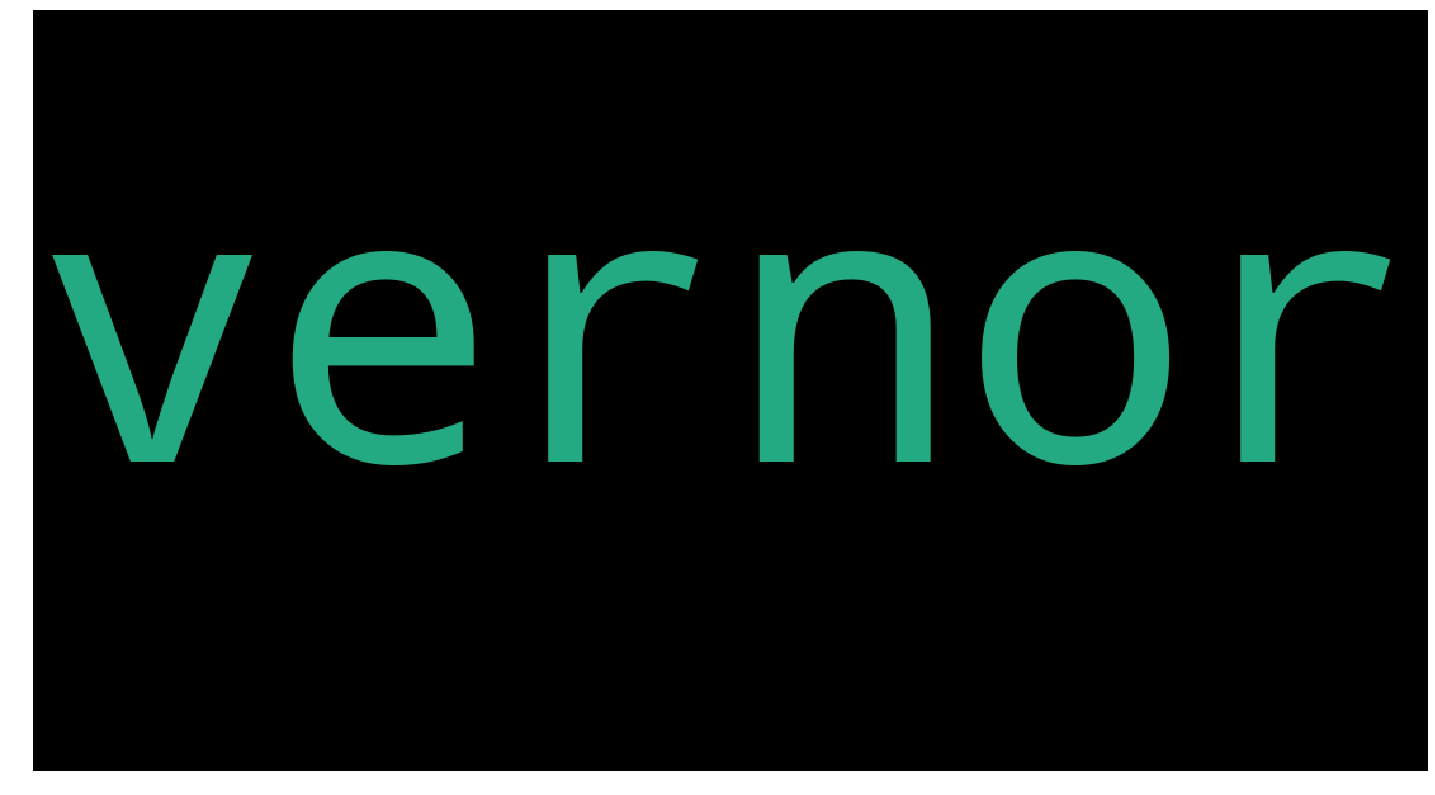

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 6 obtained by TFIDF Featurization : 0.01


In [65]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 6: " + str(TFIDF_length_C6))
print(" ")
print("Cluster 6 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C6,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 6 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Number of Reviews Classified into Cluster 7: 1
 
Cluster 7 obtained by TFIDF Featurization:


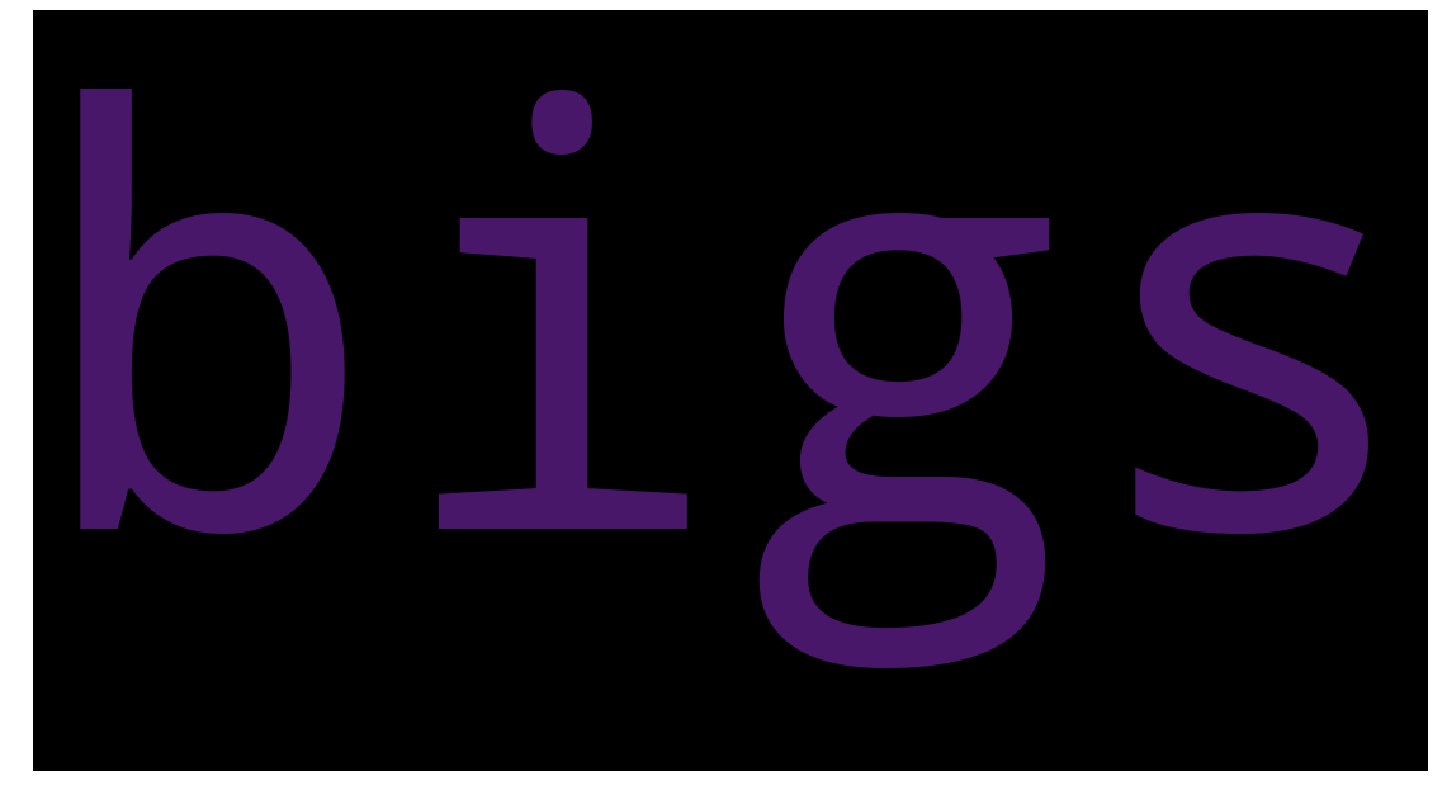

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 7 obtained by TFIDF Featurization : 0.01


In [66]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 7: " + str(TFIDF_length_C7))
print(" ")
print("Cluster 7 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C7,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 7 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Number of Reviews Classified into Cluster 8: 1
 
Cluster 8 obtained by TFIDF Featurization:


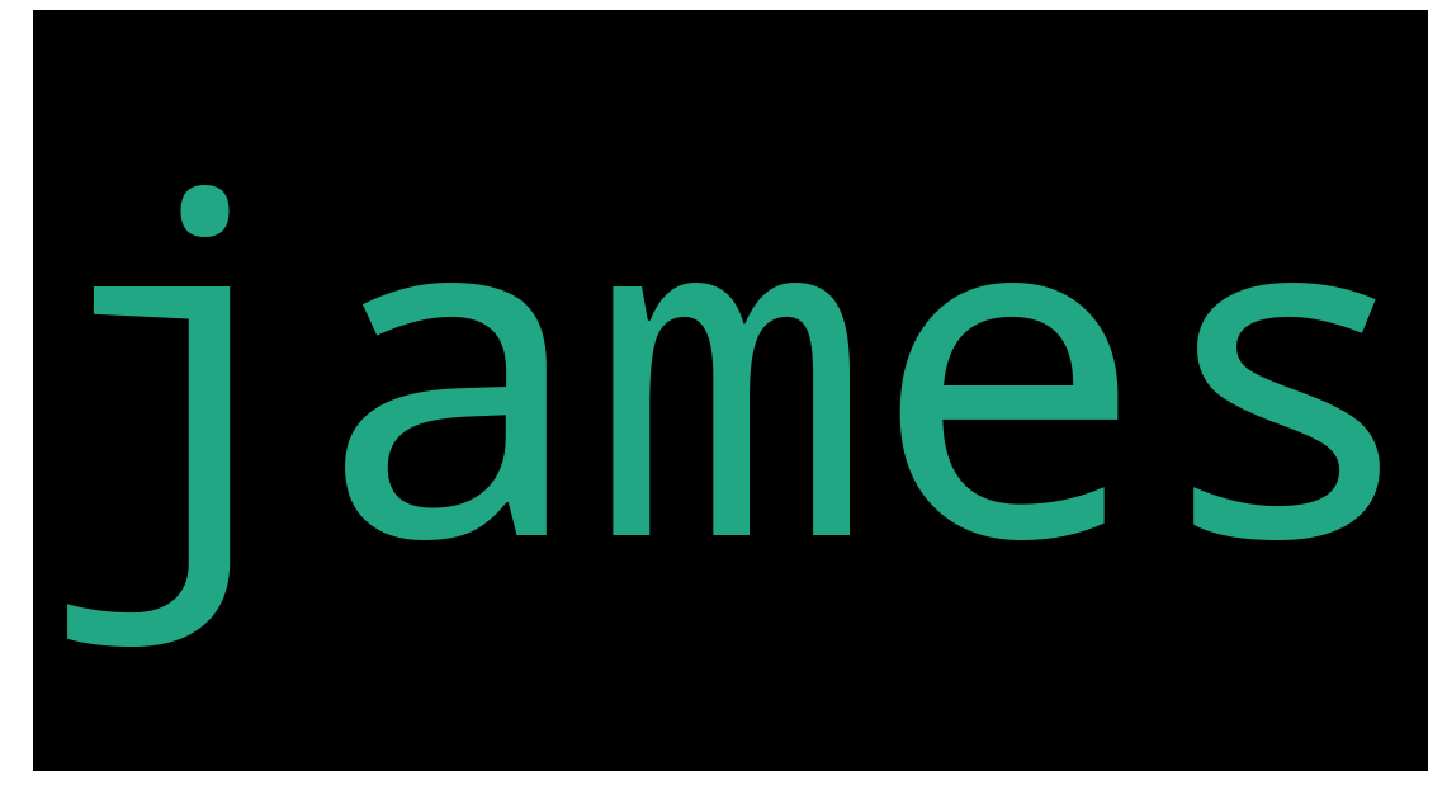

Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 8 obtained by TFIDF Featurization : 0.01


In [67]:
import time
start = time.time()

print("Number of Reviews Classified into Cluster 8: " + str(TFIDF_length_C8))
print(" ")
print("Cluster 8 obtained by TFIDF Featurization:")

Show_Wordcloud(TFIDF_indices_C8,most_important_top3000)

end = time.time()
print("Time consumed (in minutes) in obtaining the Word Cloud for the Cluster 8 obtained by TFIDF Featurization :"
      , np.round((end - start)/60,2))

Similarly, each of the remaining Clusters that we basically obtain will be single word clusters. Basically, only the first cluster (C0) is having the vast majority of words. Remaining are just single word clusters obtained.

# [5.6] Function that returns the Most Similar Words for a Given Word :-

In [68]:
def most_similar_words(input_matrix,topidf_wordlist,focus_word):
    
    cosine_distances =[]
    most_similar_words = []
    
    from scipy import spatial
    
    for word in topidf_wordlist:
        focus_word_index = topidf_wordlist.index(focus_word)
    focus_word_vectorized = input_matrix[focus_word_index]
    
    for i in input_matrix[range(input_matrix.shape[0]-1)]:
        result = spatial.distance.cosine(focus_word_vectorized,i)
        cosine_distances.append(result)
    
    indices_sorted = np.argsort(cosine_distances)
    
    for j in indices_sorted[1:6]:
        most_similar_words.append(topidf_wordlist[j]) 
        
    return most_similar_words   

* This function basically takes 3 Parameters :- The Transformed (nXk) matrix,'most_important_top3000' word list as well as the word in consideration (focus_word).
* First we obtain the index of the focus_word from our 'most_important_top3000' and obtain the vectorized form of the same in our 'transformed_SVD' matrix.
* Now we basically compute the Cosine Distance of each of these Vectors from each other. We can also obtain Cosine Similarity by subtracting the Cosine Distance from 1, but sorting and obtaining the Most Similar 5 Words becomes much easier when we consider Cosine Distance.

<b> <font color="black"> Calling the most_similar_words() Function on the 'transformed_SVD' for a Sample Word:- </font> </b>

In [71]:
print("The Top 5 Most Similar Words to the Input Word are as follows: ")
most_similar_words(transformed_SVD,most_important_top3000,'suspiciously')

The Top 5 Most Similar Words to the Input Word are as follows: 


['silent', 'rectangle', 'battling', 'render', 'deluca']

# [6] Conclusions :-

In [72]:
from prettytable import PrettyTable

a = PrettyTable()
a.field_names=["S.No.","Model","Hyperparameter","Ideal Value of Hyperparameter"]

In [73]:
print("Ideal Values of the Hyperparameters for Truncated SVD & K-Means Clustering using TFIDF Featurization : ")
print(" "*100)

a.add_row(["1","Truncated SVD","Optimal Number of Components","2332"])
a.add_row(["2","K-Means Clustering","Optimal Number of Clusters","17"])

print(a)

Ideal Values of the Hyperparameters for Truncated SVD & K-Means Clustering using TFIDF Featurization : 
                                                                                                    
+-------+--------------------+------------------------------+-------------------------------+
| S.No. |       Model        |        Hyperparameter        | Ideal Value of Hyperparameter |
+-------+--------------------+------------------------------+-------------------------------+
|   1   |   Truncated SVD    | Optimal Number of Components |              2332             |
|   2   | K-Means Clustering |  Optimal Number of Clusters  |               17              |
+-------+--------------------+------------------------------+-------------------------------+


<b> <font color="black"> Summary :- </font> </b>

* Initially we considered 100K reviews and then obtained all of our Features which we found to be greater than 12K in number. In order to Obtain the Co-Occurrence Matrix for the same, we only considered the Top 3000 of these Features based on the IDF Values that we obtained. 
* Now we computed the Co-Occurrence matrix by finding out the number of occurences of a word in another word's context, both of these words being present in the 'Top3000_features_list', and then applied Truncated SVD. 
* We obtained the Minimum Necessity of Features to explain the Variance needed to us :- 0.90 in our case, and we can conclude that nearly 665 of the least important features are contributing only around 10% of the variance. 
* Then we obtained K-Means clusters for each of the cells and from this we can conclude that our Clustering is not good at all because of a large difference in cluster sizes (a sub-optimal scenario for K-Means Clustering to work) :- One of the clusters obtained hold vast majority of the data.
* Finally we obtained the Most Similar Words to an input word, which is the crux of our Matrix Factorization & Recommender Systems.